In [1]:
import folium
import numpy as np
import pandas as pd
import commons as me
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go

In [2]:
pinnaclePoints = pd.read_csv('../data/results/pinnacle_points/prm_iso/pinnacle_points.csv')
faultyTowers = pd.read_csv('../data/clean/faulty_pinnacle_points.csv')

In [3]:
'''
Colours pinnacle point markers on the map based on elevation
'''
def getPinnaclePointColor(elevation):
    
    # Defining colors for colormap
    colors = [
        (0.0, 'limegreen'),
        (0.25, 'yellow'),
        (0.5, 'orange'),
        (0.75, 'red'),
        (1.0, 'indigo')
    ]

    # Create the colormap
    colormap = LinearSegmentedColormap.from_list('custom_colormap', colors)
    rgbaColor = colormap(elevation/pinnaclePoints.elevation.max())
    
    # Convert RGBA to HEX
    hexColor = "#{:02x}{:02x}{:02x}".format(
        int(rgbaColor[0] * 255), # Red
        int(rgbaColor[1] * 255), # Green
        int(rgbaColor[2] * 255)  # Blue
    )
    
    return hexColor

def getMarkerText(summit):

    latRounded = round(summit.latitude, 4)
    lngRounded = round(summit.longitude, 4)

    markertext = (
        # f'<b>SummitId:</b> {round(summit.summitId)}<br>' +
        f'<b>Elevation:</b> {round(summit.elevation)} m<br>' +
        f'<b>Location:</b> {latRounded}, {lngRounded}<br>' + 
        f'<a href=https://www.peakbagger.com/search.aspx?tid=R&lat={latRounded}&lon={lngRounded}&ss=>PeakBagger</a> | ' + 
        f'<a href=https://www.google.com/maps/place/{latRounded},{lngRounded}>Google Maps</a>'
    )

    return markertext

'''
Adds a summit to the pinnacle point map
'''
def addPointToMap(summit):
                
    markerText = getMarkerText(summit)

    correction = faultyTowers.query('summitId == @summit.summitId')

    if len(correction) == 1:

        latitudeTrue = correction.latitudeTrue.values[0]
        longitudeTrue = correction.longitudeTrue.values[0]
        elevationTrue = correction.elevationTrue.values[0]
        faultType = correction.type.values[0]

        summitColor = getPinnaclePointColor(elevationTrue)
        markerTextCorrection = markerText + '<br><br>Misidentified by algorithm'

        if faultType == 0:

            markerFlase = folium.RegularPolygonMarker(
                location = [summit.latitude, summit.longitude],
                number_of_sides=3,
                radius = 11,
                fill = True,
                fill_color = summitColor,
                fill_opacity = 0,
                opacity = 1,
                weight = 1,
                color = summitColor,
                gradient = False,
                rotation = 30
            ).add_to(pinnaclePointMap)
    
            # For better usability on mobile
            invisibleCircleFalse = folium.CircleMarker(
                location = [summit.latitude, summit.longitude],
                radius = 12,
                fill = True,
                fill_opacity = 0,
                weight = 0
            ).add_to(pinnaclePointMap)
                        
            invisibleCircleFalse.add_child(folium.Popup(markerTextCorrection, max_width=300).add_to(invisibleCircleFalse))
            
            # Adding a line to the true summit for misidentifications
            faultToTrueLine = [[summit.latitude, summit.longitude], [correction.latitudeTrue.values[0], correction.longitudeTrue.values[0]]]
            folium.PolyLine(faultToTrueLine, color=summitColor, weight=1, opacity=1).add_to(pinnaclePointMap)
            
            markerTrue = folium.RegularPolygonMarker(
                location = [latitudeTrue, longitudeTrue],
                number_of_sides=3,
                radius = 11,
                fill = True,
                fill_color = summitColor,
                fill_opacity = 1,
                weight = 1,
                color = 'black',
                gradient = False,
                rotation = 30
            ).add_to(pinnaclePointMap)

            # For better usability on mobile
            invisibleCircleTrue = folium.CircleMarker(
                location = [latitudeTrue, longitudeTrue],
                radius = 12,
                fill = True,
                fill_opacity = 0,
                weight = 0
            ).add_to(pinnaclePointMap)  

            invisibleCircleTrue.add_child(folium.Popup(markerText, max_width=300).add_to(invisibleCircleTrue))
        
    else:
    
        marker = folium.RegularPolygonMarker(
            location = [summit.latitude, summit.longitude],
            number_of_sides=3,
            radius = 11,
            fill = True,
            fill_color = getPinnaclePointColor(summit.elevation),
            fill_opacity = 1,
            weight = 1,
            color = 'black',
            gradient = False,
            rotation = 30
        ).add_to(pinnaclePointMap)

        # For better usability on mobile
        invisibleCircle = folium.CircleMarker(
            location = [summit.latitude, summit.longitude],
            radius = 12,
            fill = True,
            fill_opacity = 0,
            weight = 0
        ).add_to(pinnaclePointMap)
        invisibleCircle.add_child(folium.Popup(markerText, max_width=300).add_to(invisibleCircle))
    
summits = pinnaclePoints.sort_values('elevation', ascending=True)
pinnaclePointMap = folium.Map(location=[0, 0], zoom_start=3, tiles=None, world_copy_jump=True)

folium.TileLayer(name = 'Street').add_to(pinnaclePointMap)

folium.TileLayer(
          'https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png', 
          attr = '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
          name = 'Elevation',
          maxZoom = 16
          ).add_to(pinnaclePointMap)

folium.raster_layers.TileLayer(name = 'Satellite',
                               maxZoom = 17,
                               tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
                               attr = '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
                              ).add_to(pinnaclePointMap)

folium.LayerControl().add_to(pinnaclePointMap)

summits.apply(addPointToMap, axis=1)

legend_html = """
    <div style="
        background-color: rgba(255, 255, 255, 0.9);
        padding: 5px;
        font-size: 12px;
        position: absolute;
        top: 12px;
        right: 70px;
        z-index: 1000;
    ">
        <div style="cursor: pointer;" onclick="toggleLegend()">
            <div style="display: flex; align-items: center;" title="Legend">
                <div id="chevronIcon" style="margin-left: 11px; margin-right: 15px; width: 10px; height: 10px; 
                    border-style: solid; border-width: 0 3px 3px 0; transform: rotate(225deg);"></div>
                <h4 style="margin: 0; margin-right: 30px;"><b>Pinnacle Points</b></h4>
            </div>
            <div id="legendContent" style="display: block; margin-top: 5px;">
                <center style="margin-top: 15px; margin-bottom: 15px;">
                    Points from which no higher<br>point can be seen
                </center>
    
                <div style="
                  display: flex;
                  flex-direction: column;
                  align-items: center;
                  margin: 5px auto;
                ">
                      <div style="display: flex; justify-content: space-between; width: 90%; font-size: 12px; margin-bottom: 2px;">
                        <span>Elevation:</span>
                      </div>
                    
                      <div style="
                        height: 18px;
                        border-radius: 2px;
                        background: linear-gradient(to right, limegreen, yellow, orange, red, indigo);
                        box-shadow: 0 0 3px rgba(0,0,0,0.3);
                        width: 90%;
                      "></div>

                      <div style="display: flex; justify-content: space-between; width: 90%; font-size: 12px;">
                        <span>Sea Level</span>
                        <span>Mt. Everest</span>
                      </div>
                </div>
            </div>
        </div>
    </div>

    <script>
        function toggleInfoWindow() {
            var infoWindow = document.getElementById("infoWindow");
            var infoIcon = document.getElementById("informationIcon");

            if (infoWindow.style.display === "block") {
                infoWindow.style.display = "none";
                infoIcon.style.fill = "rgba(255, 255, 255, 0.9)";
            } else {
                infoWindow.style.display = "block";
                infoIcon.style.fill = "rgba(255, 255, 0, 0.9)";
            }
        }
    </script>

    <script>
        function toggleLegend() {
            var contentDiv = document.getElementById("legendContent");
            var chevronIcon = document.getElementById("chevronIcon");

            if (contentDiv.style.display === "block") {
                contentDiv.style.display = "none";
                chevronIcon.style.transform = "rotate(45deg)";
            } else {
                contentDiv.style.display = "block";
                chevronIcon.style.transform = "rotate(225deg)";
            }
        }
    </script>
"""

pinnaclePointMap.get_root().html.add_child(folium.Element(legend_html))

# pinnaclePointMap.get_root().html.add_child(folium.Element('''
#     <div id="catalogue" style="position: absolute; bottom: 94px; right: 4px; cursor: pointer; z-index: 1001;">
#         <a href="guide/">
#             <svg id="catalogueIcon" width="50" height="50" viewBox="0 0 50 50" fill="white" stroke="black"
#                 stroke-linecap="round" stroke-linejoin="round" style="fill: rgba(255, 255, 255, 0.9)">
#                 <title>Guide</title>
#                 <circle cx="24" cy="24" r="20" stroke-width="6" ></circle>
#                 <rect x="16" y="15" width="16" height="19" stroke-width="2" fill="none"></rect>
#                 <rect x="19" y="15" width="13" height="19" stroke-width="2" fill="none"></rect>
#                 <line x1="23" y1="21" x2="28" y2="21" stroke-width="2"></line>
#             </svg>
#         </a>
#     </div>
# '''))

pinnaclePointMap.get_root().html.add_child(folium.Element('''
    <div id="infoIcon" style="position: absolute; bottom: 10px; right: 0px; cursor: pointer; z-index: 1001;">
        <svg id="informationIcon" width="100" height="100" viewBox="0 0 50 50" fill="white" stroke="black" stroke-width="4" 
            stroke-linecap="round" stroke-linejoin="round" onclick="toggleInfoWindow()" style="fill: rgba(255, 255, 255, 0.9)">
            <title>Info</title>
            <circle cx="24" cy="24" r="20"></circle>
            <line x1="24" y1="32" x2="24" y2="24"></line>
            <line x1="24" y1="16" x2="24" y2="16"></line>
        </svg>
    </div>
    <div id="infoWindow" style="display: none; overflow-y: auto; position: absolute; top: 50%; left: 50%; 
        transform: translate(-50%, -50%); background-color: rgba(255, 255, 255, 0.9); padding: 30px; width: 95%; 
        height: 68%;  z-index: 1000;">
        
        <p>
            <b>Pinnacle points</b> are a points from which no higher point can be seen. In other words, 
            at a pinnacle point you would be at the highest elevation in sight. 
            Two points are defined to have line of sight if light can theoretically travel from one to the other 
            unobstructed in clear atmospheric conditions. 
            The curvature of the Earth, atmospheric refraction, and local topography are all taken into account. 
            It is possible for two pinnacle points of equal elevation to have line of sight 
            since neither is tall enough to disqualify the other.
        </p>
        
        <h2>Links</h2>
        <ul>
            <li>
                <a href="https://github.com/jgbreault/PinnaclePoints/blob/main/misc/method.txt">
                    Explanation of method
                </a>
            </li>
            <li>
                <a href="https://github.com/jgbreault/PinnaclePoints">
                    Github directory
                </a>
            </li>
            <li>
                <a href="https://www.rhsoc.uk/blog/hill-list-updates/two-classification-criteria-for-the-hills-and-mountains-of-britain/">
                    Relative Hills Society article that (briefly) mentions pinnacle points
                </a>
            </li>
        </ul>
        
        <h2>Data Sources</h2>
        <h4><a href="https://ototwmountains.com/">1. On-Top-Of-The-World Mountains</a></h4>
        <p>
            On-top-of-the-world (OTOTW) mountains are mountains where no land rises above the horizontal plane from its summit. 
            Since any land that rises above the horizontal plane would have a higher elevation than the mountain itself, 
            if a mountain is not an OTOTW mountain then it can not be a pinnacle point either. 
            In other words, pinnacle points are a subset of OTOTW mountains. 
            Kai Xu found all 6,464 OTOTW mountains on Earth with over 300 m of prominence, 
            and I have identified which qualify as pinnacle points. 
            Andreas Geyer-Schulz deserves mention as well for his 
            <a href="https://nuntius35.gitlab.io/extremal_peaks/">extremal peaks</a>, 
            a nearly identical concept to OTOTW mountains developed completely independently.
        </p>
        <h4><a href="https://www.andrewkirmse.com/prominence-update-2023">2. Mountains by Prominence</a></h4>
        <p>
            Andrew Kirmse and Jonathan de Ferranti found all 11,866,713 summits on Earth with over 100 ft (~30 m) of prominence. 
            Prominence is the minimum vertical distance one must descend to reach a higher point. 
            Kai Xu identified OTOTW mountains using this dataset, 
            so I use this dataset to identify which OTOTW mountains are pinnacle points. 
            This source primarily uses the Copernicus GLO-30 DEM.
        </p>
        <h4><a href="https://www.andrewkirmse.com/true-isolation">3. Mountains by Isolation</a></h4>
        <p>
            Andrew Kirmse and Jonathan de Ferranti found all 24,749,518 summits on Earth with over 1 km of isolation. 
            Isolation is the distance to the nearest higher point. Extreme isolation points are strong pinnacle point candidates, 
            so I use this dataset to find all pinnacle points with an isolation of at least 100 km. 
            This source uses the STRM 90m DEM.
        </p>
        <h4><a href="https://open-meteo.com/en/docs/elevation-api">4. Open-Meteo's Elevation API</a></h4>
        <p>
            Open-Meteo offers an elevation API that can be used to find the elevation of any point on Earth. 
            I host this API locally to find the elevation of points between summits that could obstruct line of sight.
            I also use this API to correct a few faulty summit elevations from the other data sources. 
            This source uses the Copernicus GLO-90 DEM.
        </p>
        <h4><a href="https://beyondrange.wordpress.com/lines-of-sight/">5. Beyond Horizons</a></h4>
        <p>
            Beyond Horizons has catalogued many of the longest lines of sight ever captured by photograph. 
            I use these confirmed lines of sight to determine how to model light bending from atmospheric refraction over great distances.
        </p>
        
        <h2>Sources of Error</h2>
        <ul>
            <li>    
                There is some inherent error in the elevation data.
            </li>
            <li>
                The Earth is approximated as a sphere instead of an ellipsoid for simpler math.
            </li>      
            <li>    
                To take atmospheric refraction into account, light rays are approximated as arcs of circles. 
                Though this is a commonly used approximation, 
                the path light takes in the atmosphere is in fact much more complex and depends on many local factors. 
                This is probably the largest source of error.
            </li>    
            <li>    
                Only summits with more than 300 m of prominence or more than 100 km of isolation are considered. 
                The prominence threshold is determined by the OTOTW mountain dataset. 
                The isolation threshold was chosen arbitrarily to be a pretty number that 
                my algorithm can handle in a reasonable amount of time.
            </li>   
            <li>    
                When doing line of sight analysis, 
                a discrete number of points between the observer and target are sampled to see if the ground obstructs line of sight. 
                The samples are at most 100 m apart. 
                It is possible for points that would block line of sight to not be captured. 
                By increasing the number of samples, more pinnacle points could be found.
            </li>
        </ul>
    </div>
'''))

pinnaclePointMap

In [4]:
pinnaclePointMap.save('../index.html')

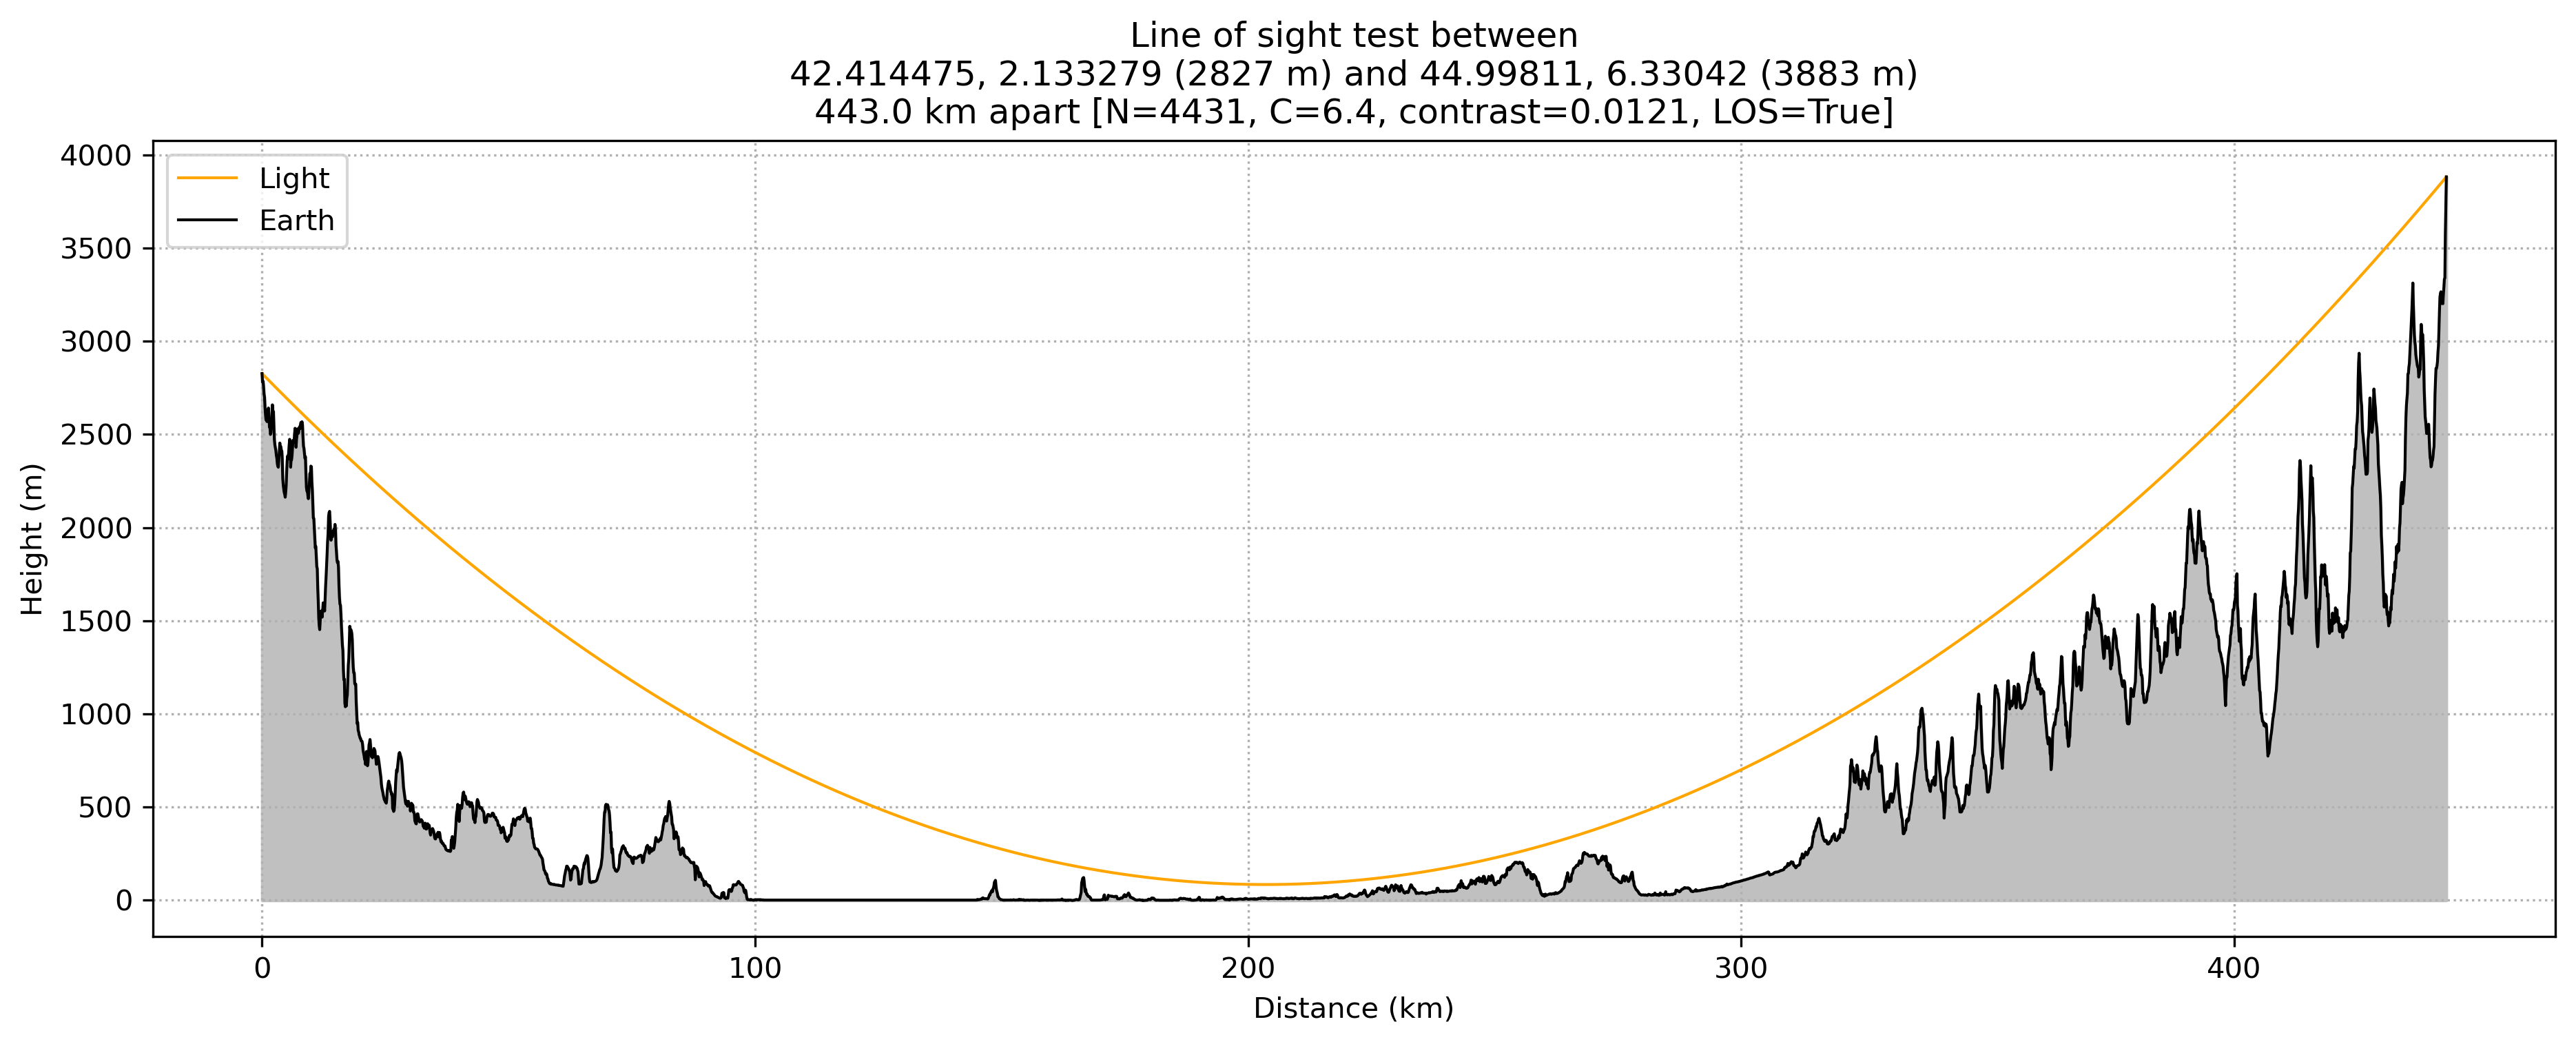

In [2]:
obs = me.Summit(42.414475, 2.133279, 2827)
trg = me.Summit(44.99811, 6.33042, 3883)
los = me.LineOfSight(obs, trg)
los.processFullLineOfSight()
los.plot('../misc/images/longest_confirmed_LOS')
los.plot2()

In [5]:
me.getElevations([69.2775], [-144.91])[0]

2670.0

In [7]:
observer = me.Summit(
    summitId = -454766,
    latitude = 69.2775, 
    longitude = -144.91,
    elevation = 2712)

observer.isPinnaclePoint()

Potential Disqualifying Summits: 1
Tested Potential Disqualifying Summits: 1
In view of 69.2025, -143.8011 (2721 m) 44 km away
Pinnacle Point: False


False

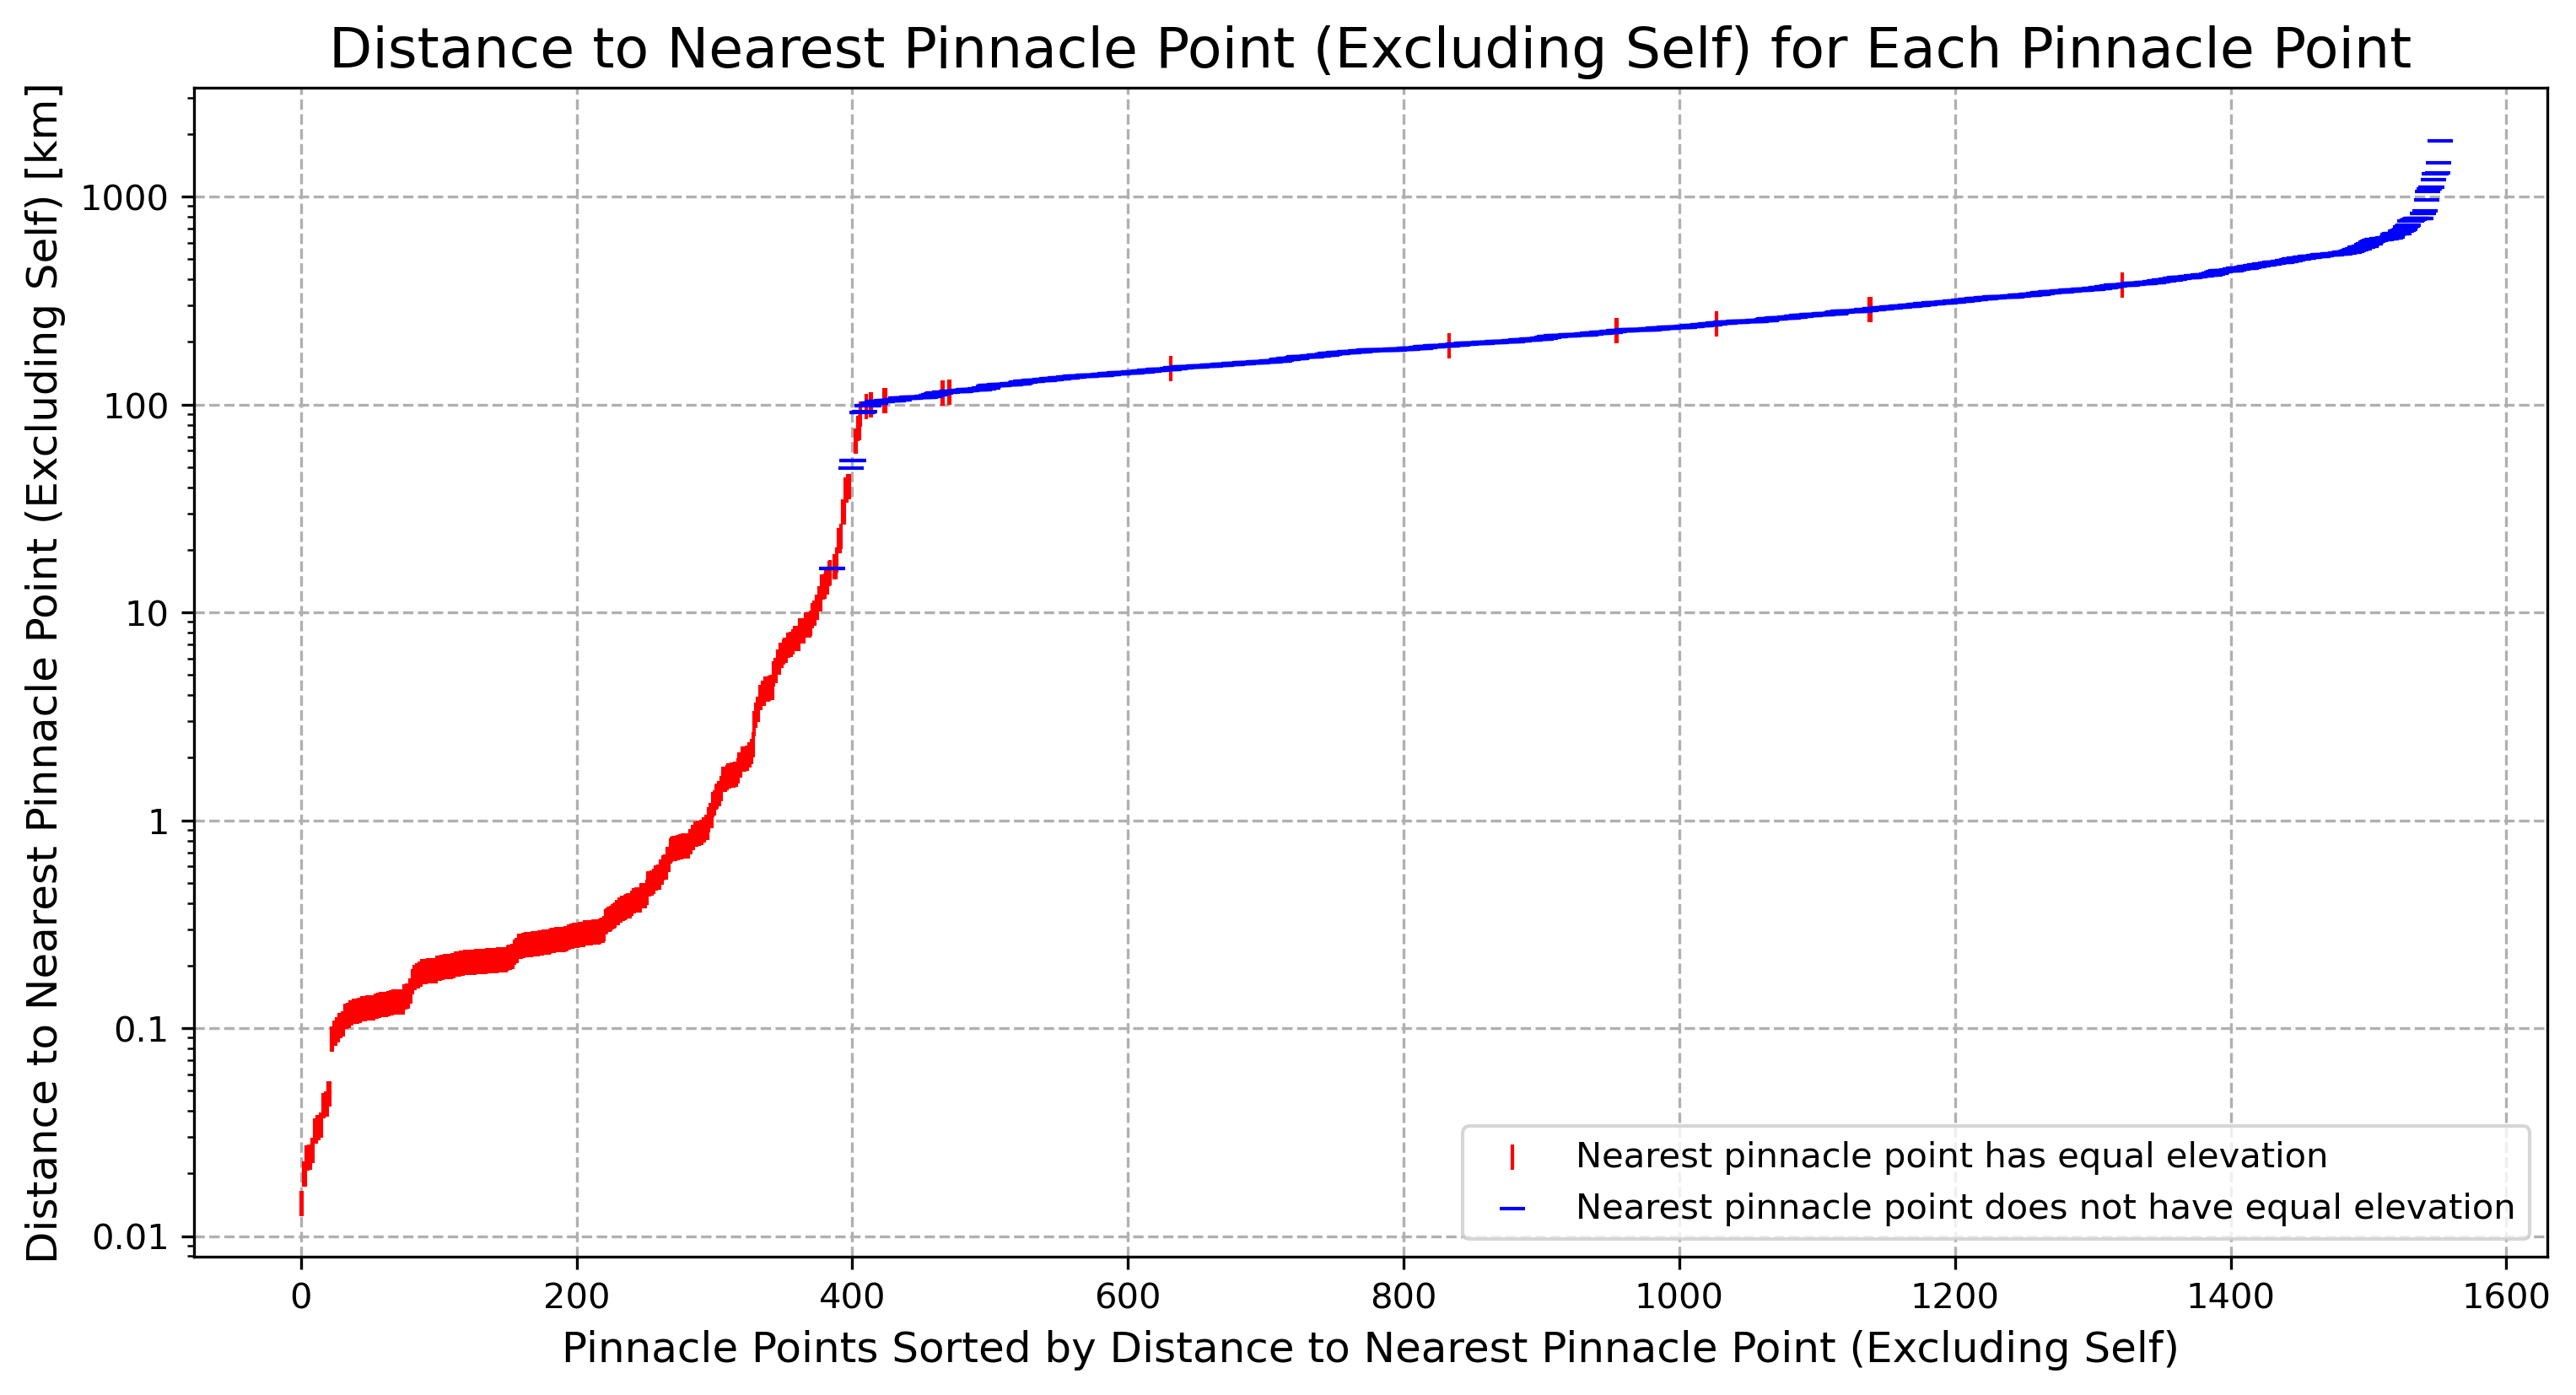

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

def distance(lat1, lon1, lat2, lon2):
    return me.geod.line_length([lon2, lon1], [lat2, lat1])

def find_nearest(row, df):
    # compute distances to all other points
    distances = df.apply(
        lambda r: distance(row.latitude, row.longitude, r.latitude, r.longitude) if r.summitId != row.summitId else np.inf,
        axis=1
    )
    # index of the minimum distance
    idx_min = distances.idxmin()
    return pd.Series({
        "closest_Id": df.loc[idx_min, "summitId"],
        "closest_dist_km": distances[idx_min],
        "closest_elv": df.loc[idx_min, "elevation"]
    })

pinnaclePoints[["closest_Id", "closest_dist", "closest_elv"]] = pinnaclePoints.apply(find_nearest, df=pinnaclePoints, axis=1)

pinnaclePoints = pinnaclePoints.sort_values("closest_dist")
x = range(len(pinnaclePoints))

mask = pinnaclePoints["closest_elv"] == pinnaclePoints["elevation"]

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.scatter([i for i, m in zip(x, mask) if m],
           pinnaclePoints["closest_dist"].divide(1000)[mask], 
           s=50, marker='|', color='red', zorder=2, 
           linewidth=1,
           label="Nearest pinnacle point has equal elevation")

ax.scatter([i for i, m in zip(x, mask) if not m],
           pinnaclePoints["closest_dist"].divide(1000)[~mask], 
           s=50, marker='_', color='blue', zorder=2,
           linewidth=1, 
           label="Nearest pinnacle point does not have equal elevation")

ax.set_yscale("log")
ax.grid(True, which="major", ls="--", zorder=0)

fig.patch.set_facecolor("white")

ax.set_title("Distance to Nearest Pinnacle Point (Excluding Self) for Each Pinnacle Point", fontsize=16)
ax.set_xlabel("Pinnacle Points Sorted by Distance to Nearest Pinnacle Point (Excluding Self)", fontsize=12)
ax.set_ylabel("Distance to Nearest Pinnacle Point (Excluding Self) [km]", fontsize=12)

ax.set_yticks([0.01, 0.1, 1, 10, 100, 1000])
ax.set_yticklabels(["0.01", "0.1", "1", "10", "100", "1000"])

ax.legend(loc=4, facecolor="white")
fig.savefig("../misc/images/distance_to_nearest_pinnacle_point", bbox_inches="tight")
plt.show()

In [15]:
truePP = pinnaclePoints.query('closest_elv != elevation').sort_values('closest_dist')
truePP.head(10)

summitId  latitude  longitude  elevation  closest_Id  closest_dist  \
922   -9517576  -78.7183   -68.4442     385.00  -8798433.0  16321.492779   
898   -8798433  -78.8258   -68.9575     410.00  -9517576.0  16321.492779   
1468 -23436700  -22.2800  -138.7575      15.85 -23307721.0  49641.930770   
314    2137310   47.5422   120.4800    1729.63   2099348.0  53955.385760   
311    2099348   47.0578   120.5219    1747.47   2137310.0  53955.385760   
236    1390215  -71.0136    65.1467    2176.70   1352606.0  91985.756706   
231    1352606  -70.1944    64.8000    2208.16   1390215.0  91985.756706   
302    2012966   -9.2442    27.8183    1789.60   -869899.0  92691.277130   
570    5740538   49.5942   -57.7842     802.45  -4239419.0  98709.813217   
563   -4239419   48.8333   -58.4842     811.99   5740538.0  98709.813217   

      closest_elv  
922        410.00  
898        385.00  
1468        18.00  
314       1747.47  
311       1729.63  
236       2208.16  
231       2176.70  
302       1909.88  
570        811.99  
563        802.45